In [ ]:
from ultralytics import YOLO
from pathlib import Path
import os
import shutil

# Paths
DATA_PATH = Path("../data/images_classified")  
PROJECT_NAME = "greenery_classification"       # name of the training run
RUNS_PATH = Path("../runs")                    # output directory

# Training parameters
MODEL_SIZE = "n"      # nano
EPOCHS = 50
BATCH_SIZE = 16
IMAGE_SIZE = 128
PATIENCE = 20         # early stopping patience

CLASS_NAMES = ["greenery", "non_greenery"]

# TRAINING

def train_model():
    """Trains the YOLO classification model."""
    print("\n" + "=" * 70)
    print(" STARTING TRAINING")
    print("=" * 70)

    model_path = f"yolov8{MODEL_SIZE}-cls.pt"

    # Check pretrained weights
    weights_dir = Path("./weights")
    weights_dir.mkdir(exist_ok=True)
    weight_file = weights_dir / model_path

    if not weight_file.exists():
        import urllib.request
        url = f"https://github.com/ultralytics/assets/releases/download/v0.0.0/{model_path}"
        print(f"⬇ Downloading pretrained weights: {url}")
        urllib.request.urlretrieve(url, weight_file)
        print(" Download complete.")

    # Load model
    model = YOLO(str(weight_file))

    # Train
    results = model.train(
        data=str(DATA_PATH),
        epochs=EPOCHS,
        batch=BATCH_SIZE,
        imgsz=IMAGE_SIZE,
        patience=PATIENCE,
        project=str(RUNS_PATH),
        name=PROJECT_NAME,
        exist_ok=True,
        plots=True,
    )

    best_model_path = RUNS_PATH / PROJECT_NAME / "weights" / "best.pt"
    print(f"\n Best model saved at: {best_model_path}")

    return model, best_model_path

# VALIDATION + TEST

def evaluate_model(model_path):
    """Runs validation and test."""
    model = YOLO(str(model_path))

    # Validation
    val_metrics = model.val(split="val")
    print(f"\n Validation Top-1 Accuracy: {val_metrics.top1:.2%}")

    # Test
    test_metrics = model.val(split="test")
    print(f"\n Test Top-1 Accuracy: {test_metrics.top1:.2%}")

    return val_metrics, test_metrics

# EXAMPLE PREDICTIONS

def predict_examples(model_path, num_samples=10):
    """Predicts several random samples from the test set."""
    model = YOLO(str(model_path))

    test_images = []
    for cls in CLASS_NAMES:
        cls_images = list((DATA_PATH / "test" / cls).glob("*.jpg"))[:num_samples // 2]
        test_images.extend(cls_images)

    if not test_images:
        print(" No test images found!")
        return

    print(f"\n Predictions for {len(test_images)} sample images:\n")

    for img_path in test_images:
        results = model.predict(img_path, verbose=False)
        probs = results[0].probs

        top1_idx = probs.top1
        top1_conf = probs.top1conf.item()

        predicted_class = CLASS_NAMES[top1_idx]
        true_class = img_path.parent.name

        status = "✅" if predicted_class == true_class else "❌"

        print(
            f"{status} {img_path.name:<30} "
            f"True: {true_class:<13} | Pred: {predicted_class:<13} "
            f"({top1_conf:.2%})"
        )


# MAIN

def main():
    print(" YOLO GREENERY CLASSIFICATION PIPELINE")


    if not DATA_PATH.exists():
        print(f" Dataset not found: {DATA_PATH}")
        return

    # Training
    model, best_model_path = train_model()

    # Evaluation
    val_metrics, test_metrics = evaluate_model(best_model_path)

    # Example Predictions
    predict_examples(best_model_path, num_samples=20)

    print("\n PIPELINE COMPLETE!")
    print(f"All results saved in: {RUNS_PATH / PROJECT_NAME}")


if __name__ == "__main__":
    main()

 YOLO GREENERY CLASSIFICATION PIPELINE

 STARTING TRAINING
Ultralytics 8.3.229  Python-3.11.3 torch-2.9.1+cpu CPU (AMD Ryzen 5 2600 Six-Core Processor)
Ultralytics 8.3.229  Python-3.11.3 torch-2.9.1+cpu CPU (AMD Ryzen 5 2600 Six-Core Processor)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=..\data\images_classified, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=128, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=weights\yolov8n-cls.pt, momentum=0.937, mosai

In [2]:
from ultralytics import YOLO
from pathlib import Path
import rasterio
from rasterio.windows import Window
from rasterio.transform import from_bounds
import geopandas as gpd
import numpy as np
from PIL import Image
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# CONFIGURATION
MODEL_PATH = Path("../runs/greenery_classification/weights/best.pt")
GRID_PATH = Path("../data/grid/Mlalakua_merged_PPK_ycbr_filtered.gpkg")  
RAW_DATA_PATH = Path("../data/raw")
OUTPUT_PATH = Path("../results/classification_maps")
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

TIF_FILE = "Mlalakua_Merged_PPK_ycbr.tif"

IMAGE_SIZE = 128  # Same as training
CONFIDENCE_THRESHOLD = 0.5  # Minimum confidence for classification

class TIFClassifier:
    def __init__(self, model_path, grid_path):
        """Initialize classifier with model and grid."""
        print("Loading YOLO model...")
        self.model = YOLO(str(model_path))
        
        print("Loading grid...")
        self.grid = gpd.read_file(grid_path)
        print(f"Grid loaded: {len(self.grid)} cells")
        
        
        print(f"Grid columns: {self.grid.columns.tolist()}")
        if 'value' in self.grid.columns:
            print(f"Grid values range: {self.grid['value'].min()} - {self.grid['value'].max()}")
        
    
    def prepare_grid(self, tif_path):
        """Prepare grid in TIF CRS."""
        with rasterio.open(tif_path) as src:
            tif_crs = src.crs
            print(f"TIF CRS: {tif_crs}")
            
            # Convert grid to TIF CRS if different
            if self.grid.crs != tif_crs:
                print(f"Converting grid from {self.grid.crs} to {tif_crs}...")
                grid_in_tif_crs = self.grid.to_crs(tif_crs)
            else:
                grid_in_tif_crs = self.grid.copy()
            
            print(f"Processing all {len(grid_in_tif_crs)} grid cells")
            return grid_in_tif_crs, tif_crs
    
    def extract_cell_image(self, src, cell_geom, target_size=IMAGE_SIZE):
        """Extract image patch for a grid cell from raster."""
        try:
            # Get cell bounds
            minx, miny, maxx, maxy = cell_geom.bounds
            
            # Calculate pixel coordinates
            row_start, col_start = src.index(minx, maxy)
            row_stop, col_stop = src.index(maxx, miny)
            
            # Ensure positive dimensions
            if row_start > row_stop:
                row_start, row_stop = row_stop, row_start
            if col_start > col_stop:
                col_start, col_stop = col_stop, col_start
            
            # Read window
            window = Window(col_start, row_start, 
                          col_stop - col_start, 
                          row_stop - row_start)
            
            # Read data (first 3 bands for RGB)
            img_array = src.read([1, 2, 3], window=window)
            
            # Check if window is valid
            if img_array.size == 0 or img_array.shape[1] == 0 or img_array.shape[2] == 0:
                return None
            
            # Convert to HWC format
            img_array = np.transpose(img_array, (1, 2, 0))
            
            # Check for no-data
            if np.all(img_array == 0) or np.all(np.isnan(img_array)):
                return None
            
            # Normalize if needed (assuming 8-bit or 16-bit)
            if img_array.max() > 255:
                img_array = (img_array / img_array.max() * 255).astype(np.uint8)
            else:
                img_array = img_array.astype(np.uint8)
            
            # Create PIL Image and resize
            img = Image.fromarray(img_array)
            img = img.resize((target_size, target_size), Image.LANCZOS)
            
            return img
            
        except Exception as e:
            return None
    
    def classify_cell(self, img):
        """Classify a single cell image."""
        if img is None:
            return None, 0.0
        
        try:
            # Run prediction
            results = self.model.predict(img, verbose=False)
            probs = results[0].probs
            
            # Get top prediction
            top1_idx = probs.top1
            confidence = probs.top1conf.item()
            
            # Class names: 0=greenery, 1=non_greenery
            class_name = "greenery" if top1_idx == 0 else "non_greenery"
            
            return class_name, confidence
            
        except Exception as e:
            print(f"Error in classification: {e}")
            return None, 0.0
    
    def process_tif(self, tif_path):
        """Process TIF file with grid."""
        print(f"\n{'='*70}")
        print(f"Processing: {tif_path.name}")
        print(f"{'='*70}")
        
        # Prepare grid in TIF CRS
        grid_cells, tif_crs = self.prepare_grid(tif_path)
        
        # Prepare results storage
        results = []
        
        # Open TIF
        with rasterio.open(tif_path) as src:
            print(f"TIF Info: {src.width}x{src.height} pixels, {src.count} bands")
            
            # Process each cell
            for idx, row in tqdm(grid_cells.iterrows(), 
                                total=len(grid_cells),
                                desc="Classifying cells"):
                
                # Extract image patch
                cell_img = self.extract_cell_image(src, row.geometry)
                
                # Classify
                class_name, confidence = self.classify_cell(cell_img)
                
                # Store results with original grid attributes
                result = {
                    'cell_id': idx,
                    'class': class_name,
                    'confidence': confidence,
                    'geometry': row.geometry
                }
                
                # Add original grid value if exists
                if 'value' in row.index:
                    result['grid_value'] = row['value']
                
                results.append(result)
        
        # Create GeoDataFrame
        results_gdf = gpd.GeoDataFrame(results, crs=tif_crs)
        
        # Filter by confidence
        valid_results = results_gdf[
            (results_gdf['class'].notna()) & 
            (results_gdf['confidence'] >= CONFIDENCE_THRESHOLD)
        ].copy()
        
        print(f"\nResults Summary:")
        print(f"  Total cells processed: {len(results_gdf)}")
        print(f"  Valid classifications: {len(valid_results)}")
        print(f"  Greenery cells: {len(valid_results[valid_results['class'] == 'greenery'])}")
        print(f"  Non-greenery cells: {len(valid_results[valid_results['class'] == 'non_greenery'])}")
        
        if len(valid_results) > 0:
            print(f"  Mean confidence: {valid_results['confidence'].mean():.2%}")
        
        return valid_results
    
    def save_results(self, results_gdf, tif_name):
        """Save classification results to GeoPackage and CSV."""
        if results_gdf is None or len(results_gdf) == 0:
            print("  No results to save!")
            return
        
        base_name = tif_name.replace('.tif', '')
        
        # Save as GeoPackage
        gpkg_path = OUTPUT_PATH / f"{base_name}_classified.gpkg"
        results_gdf.to_file(gpkg_path, driver="GPKG")
        print(f" Saved GeoPackage: {gpkg_path}")
        
        # Save as CSV (without geometry)
        csv_path = OUTPUT_PATH / f"{base_name}_classified.csv"
        results_df = pd.DataFrame(results_gdf.drop(columns='geometry'))
        results_df.to_csv(csv_path, index=False)
        print(f" Saved CSV: {csv_path}")
        
        # Create summary statistics
        summary = {
            'tif_name': tif_name,
            'total_cells': len(results_gdf),
            'greenery_cells': len(results_gdf[results_gdf['class'] == 'greenery']),
            'non_greenery_cells': len(results_gdf[results_gdf['class'] == 'non_greenery']),
            'greenery_percentage': len(results_gdf[results_gdf['class'] == 'greenery']) / len(results_gdf) * 100,
            'mean_confidence': results_gdf['confidence'].mean()
        }
        
        print(f"\n Classification Summary:")
        print(f"   Greenery: {summary['greenery_percentage']:.1f}%")
        print(f"   Mean confidence: {summary['mean_confidence']:.2%}")
        
        return summary

def main():
    """Main processing pipeline."""
    print("="*70)
    print(" YOLO TIF CLASSIFICATION - MLALAKUA")
    print("="*70)
    
    # Check files exist
    if not MODEL_PATH.exists():
        print(f" Model not found: {MODEL_PATH}")
        return
    
    if not GRID_PATH.exists():
        print(f" Grid not found: {GRID_PATH}")
        return
    
    tif_path = RAW_DATA_PATH / TIF_FILE
    if not tif_path.exists():
        print(f" TIF not found: {tif_path}")
        return
    
    # Initialize classifier
    classifier = TIFClassifier(MODEL_PATH, GRID_PATH)
    
    # Process TIF
    results = classifier.process_tif(tif_path)
    
    # Save results
    if results is not None:
        summary = classifier.save_results(results, TIF_FILE)
        
        # Save summary
        summary_df = pd.DataFrame([summary])
        summary_path = OUTPUT_PATH / "mlalakua_classification_summary.csv"
        summary_df.to_csv(summary_path, index=False)
        print(f"\n Summary saved: {summary_path}")
    
    print(f"\n{'='*70}")
    print(" CLASSIFICATION COMPLETE!")
    print(f"{'='*70}")
    print(f"Results saved in: {OUTPUT_PATH}")

if __name__ == "__main__":
    main()

 YOLO TIF CLASSIFICATION - MLALAKUA
Loading YOLO model...
Loading grid...
Loading grid...
Grid loaded: 398225 cells
Grid columns: ['tile_id', 'row', 'col', 'geometry']

Processing: Mlalakua_Merged_PPK_ycbr.tif
Grid loaded: 398225 cells
Grid columns: ['tile_id', 'row', 'col', 'geometry']

Processing: Mlalakua_Merged_PPK_ycbr.tif
TIF CRS: EPSG:32737
Processing all 398225 grid cells
TIF Info: 123418x79621 pixels, 3 bands
TIF CRS: EPSG:32737
Processing all 398225 grid cells
TIF Info: 123418x79621 pixels, 3 bands


Classifying cells: 100%|██████████| 398225/398225 [1:02:17<00:00, 106.54it/s]




Results Summary:
  Total cells processed: 398225
  Valid classifications: 372213
  Greenery cells: 129322
  Non-greenery cells: 242891
  Mean confidence: 90.98%
 Saved GeoPackage: ..\results\classification_maps\Mlalakua_Merged_PPK_ycbr_classified.gpkg
 Saved GeoPackage: ..\results\classification_maps\Mlalakua_Merged_PPK_ycbr_classified.gpkg
 Saved CSV: ..\results\classification_maps\Mlalakua_Merged_PPK_ycbr_classified.csv

 Classification Summary:
   Greenery: 34.7%
   Mean confidence: 90.98%

 Summary saved: ..\results\classification_maps\mlalakua_classification_summary.csv

 CLASSIFICATION COMPLETE!
Results saved in: ..\results\classification_maps
 Saved CSV: ..\results\classification_maps\Mlalakua_Merged_PPK_ycbr_classified.csv

 Classification Summary:
   Greenery: 34.7%
   Mean confidence: 90.98%

 Summary saved: ..\results\classification_maps\mlalakua_classification_summary.csv

 CLASSIFICATION COMPLETE!
Results saved in: ..\results\classification_maps


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_23780\2037488840.py:55: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax1.legend(loc='upper right', fontsize=12)
C:\Users\Nutzer\AppData\Local\Temp\ipykernel_23780\2037488840.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc='upper right', fontsize=12)


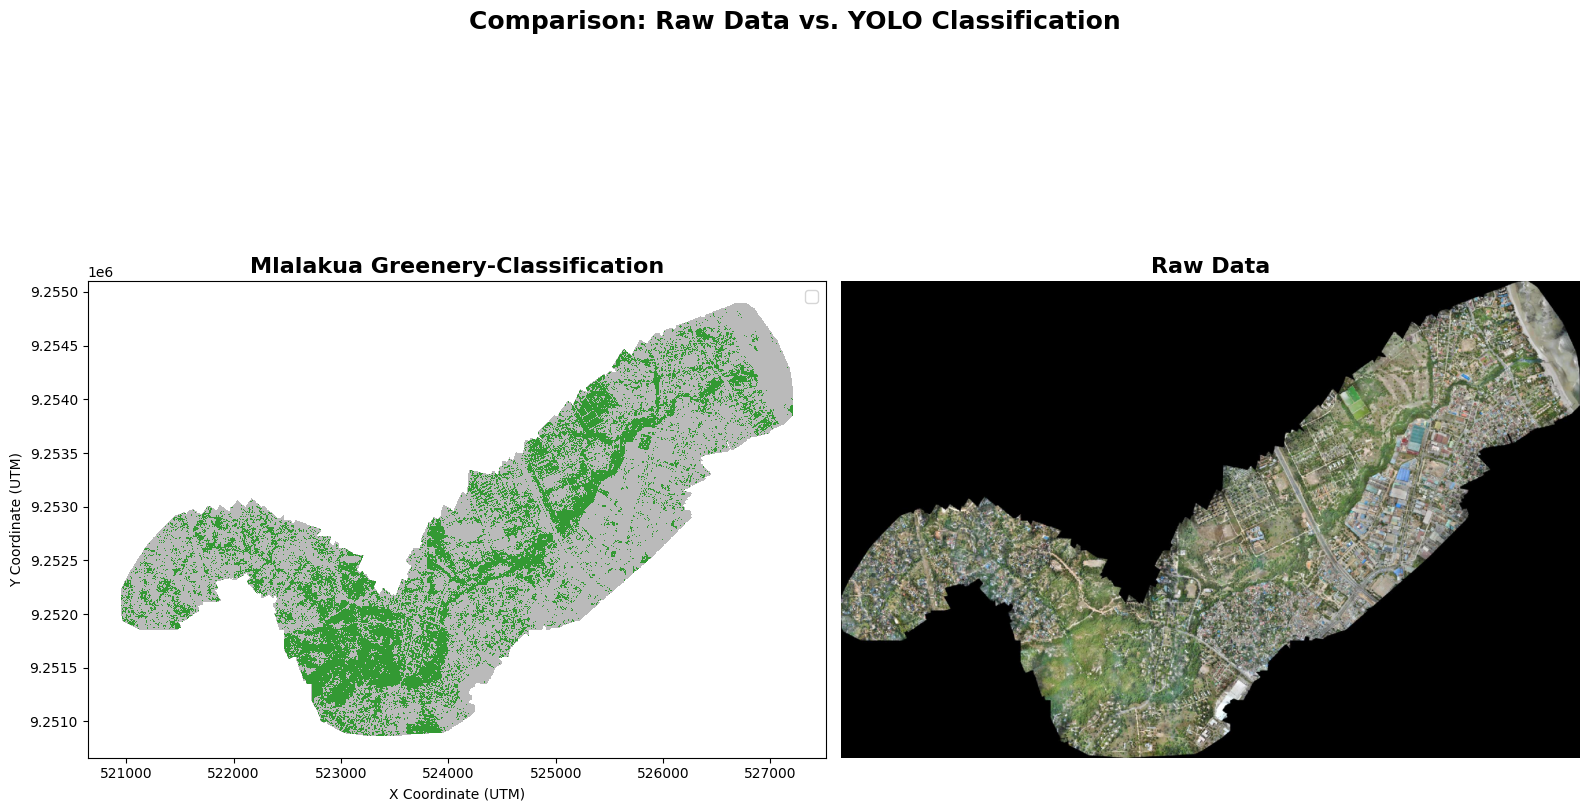

In [2]:
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from pathlib import Path
import numpy as np


OUTPUT_PATH = Path("../results/classification_maps") 
RAW_DATA_PATH = Path("../data/raw")
TIF_FILE = "Mlalakua_Merged_PPK_ycbr.tif"
CLASSIFIED_FILE = "Mlalakua_Merged_PPK_ycbr_classified.gpkg"

# Downsampling factor (Important for displaying large TIFs)
scale_factor = 0.01 

#  DATA

# Load classification results
results_gdf = gpd.read_file(OUTPUT_PATH / CLASSIFIED_FILE)

# Load raw TIF data and downsample
tif_path = RAW_DATA_PATH / TIF_FILE

with rasterio.open(tif_path) as src:
    # Read the first 3 bands (RGB) with downsampling
    overview = src.read(
        [1, 2, 3], 
        out_shape=(
            3, 
            int(src.height * scale_factor), 
            int(src.width * scale_factor)
        )
    )
    
    # Convert (C, H, W) -> (H, W, C) for Matplotlib
    raw_data_rgb = overview.transpose((1, 2, 0))
    


# CREATE PLOT

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

# Subplot 1: Classification Results

greenery = results_gdf[results_gdf['class'] == 'greenery']
non_greenery = results_gdf[results_gdf['class'] == 'non_greenery']

greenery.plot(ax=ax1, color='green', alpha=0.8, label='Greenery', edgecolor='none')
non_greenery.plot(ax=ax1, color='darkgray', alpha=0.8, label='Non-Greenery', edgecolor='none')

ax1.set_title('Mlalakua Greenery-Classification', fontsize=16, fontweight='bold')
ax1.set_xlabel('X Coordinate (UTM)')
ax1.set_ylabel('Y Coordinate (UTM)')
ax1.legend(loc='upper right', fontsize=12)

# Raw Data 

ax2.imshow(raw_data_rgb)
ax2.axis('off')
ax2.set_title('Raw Data', fontsize=16, fontweight='bold')

plt.suptitle("Comparison: Raw Data vs. YOLO Classification", fontsize=18, fontweight='heavy')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()